# 4.0 Retrieving Data from OpenStreetMap

*Gabriele Filomena has readapted the parts of the Notebook from this [notebook](https://github.com/mszell/geospatialdatascience/blob/main/unit08_openstreetmap/lecture08.ipynb)*
Copyright (c) Michael Szell. Original sources include:
 
* OSMnx examples: https://github.com/gboeing/osmnx-examples
* pyrosm examples: https://pyrosm.readthedocs.io/en/latest/basics.html#read-street-networks

## What is OpenStreetMap?

OpenStreetMap is a free and open map service. It is a collaborative global effort to collect free and open geodata. *Source: [wiki.openstreetmap.org](https://wiki.openstreetmap.org/wiki/Logos)*. OpenStreetMap (OSM) is a global collaborative (crowd-sourced) database and project that aims at creating a free editable map of the world containing of information about our environment. It contains data about streets, buildings,different services, and landuse, to mention just a few.

OSM has more than 8 million registered users who contribute around 4 million changes daily.  Its database contains data that is described by [more than 7 billion nodes](http://wiki.openstreetmap.org/wiki/Stats) (that make up lines, polygons and other objects). While the most well-known side of OpenStreetMap is the map itself, the project is much more than that. OSM’s data can be used for many other purposes such as **routing**, **geocoding**, **education**, and **research**. OSM is also widely used for humanitarian response, e.g., in crisis areas (e.g. after natural disasters) and for fostering economic development. Read more about humanitarian projects that use OSM data from the [Humanitarian OpenStreetMap Team (HOTOSM) website](https://www.hotosm.org).

## Main tools in this lesson
### OSMnx
This week we will explore a Python package called [`OSMnx`](https://github.com/gboeing/osmnx) that can be used to retrieve street networks from OpenStreetMap, and construct, analyse, and visualise them. `OSMnx` can also fetch most of the other data stored in OSM, such as building footprints, transport networks, parks, Points of Interest, etc..`OSMNx` also includes tools to find routes on a network downloaded from OpenStreetMap, and implements algorithms for finding shortest connections for walking, cycling, or driving.

To get an overview of the capabilities of the package, please refer to the following scientific article describing the package:

> Boeing, G. 2017. ["OSMnx: New Methods for Acquiring, Constructing, Analyzing, > and Visualizing Complex Street > Networks."](https://www.researchgate.net/publication/309738462_OSMnx_New_Methods_for_Acquiring_Constructing_Analyzing_and_Visualizing_Complex_Street_Networks)
> Computers, Environment and Urban Systems 65, 126-139.
> doi:10.1016/j.compenvurbsys.2017.05.004

### NetworkX
We will also use [`NetworkX`](https://networkx.github.io/documentation//) to manipulate and analyse the street network data retrieved from OpenStreetMap. NetworkX is a Python package that can be used to create, manipulate, and study the structure, dynamics, and functions of complex networks. `OSMNx` is built on top `NetworkX` and `GeoPandas`.

In [1]:
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd

%matplotlib inline

## 4.1 Download, manipulate, and visualise OpenStreetMap data with OSMnx

A useful feature of `OSMNx` is its easy-to-use tools to download [OpenStreetMap](http://www.openstreetmap.org) data via the project’s [OverPass API](http://wiki.openstreetmap.org/wiki/Overpass_API). In this section, we will learn how to download and visualise the street network and additional data from OpenStreetMap covering different areas of interest.


### Street network
The [`osmnx.graph`module](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.graph) downloads data to construct a routable road network graph, based on an user-defined area of interest. This area of interest can be specified, for instance, using a place name, a bounding box, or a polygon. In the place name query, OSMnx uses the Nominatim Geocoding API. This means that place names should exist in the OpenStreetMap database (run a test search at [openstreetmap.org](https://www.openstreetmap.org/) or [nominatim.openstreetmap.org](https://nominatim.openstreetmap.org/ui/search.html)).

### 4.1.2: Boundaries from OpenStreetMap

`OSMnx` lets you download place boundary geometries from OpenStreetMap, project them, and plot them. For a more in-depth demonstration of querying by place, see [this notebook](03-graph-place-queries.ipynb).

**Alert: data downloaded from OSM are always in the WGS crs. You need to convert it for any type of spatial operation or computation to the appropriate coordinate reference system.**

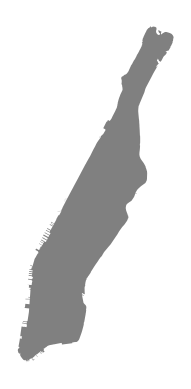

In [18]:
# get the boundary polygon for manhattan, project it, and plot it
city = ox.geocode_to_gdf("Manhattan")
ax = city.plot(fc="gray", ec="none")
ax.axis("off")

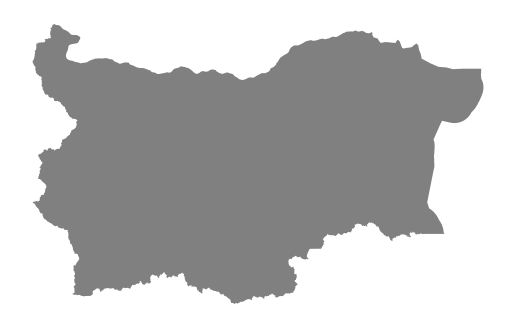

In [19]:
bulgaria = ox.geocode_to_gdf("Bulgaria")
ax = bulgaria.plot(fc="gray", ec="none")
ax.axis("off")

(-3.33146751, -1.8419154899999999, 52.90935472, 53.74221928)

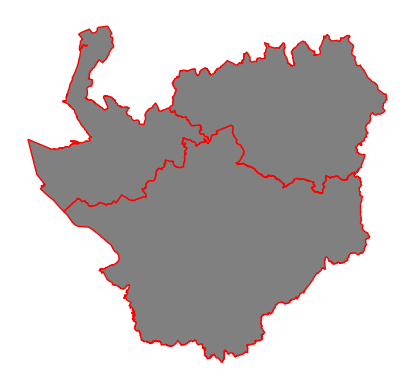

In [23]:
# get boundary polygons for several authorities in the UK, and plot
place_names = ["Merseyside", "Greater Manchester", "Cheshire"]
places = ox.geocode_to_gdf(place_names)
ax = places.plot(fc="gray", ec="red")
_ = ax.axis("off")

## 4.1.3: Download and model street networks
`OSMnx` lets you download street network data and build topologically-corrected street networks, plot the networks, and save the street network as SVGs, GraphML files, GeoPackages, or shapefiles for later use. The street networks are directed and preserve one-way directionality. For a more in-depth demonstration of creating street networks, see [this notebook](03-graph-place-queries.ipynb).

You can download a street network by providing OSMnx any of the following (demonstrated in the examples below):
  - a bounding box
  - a lat-long point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries
  - a .osm formatted xml file

You can also specify several different network types:
  - `drive` - get drivable public streets (but not service roads)
  - `drive_service` - get drivable streets, including service roads
  - `walk` - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - `bike` - get all streets and paths that cyclists can use
  - `all` - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
  - `all_private` - download all OSM streets and paths, including private-access ones

 #### Method #1: pass a bounding box ####
 This constructs the network from all the OSM nodes and ways within the bounding box. The plot function is built on `Matplotlib`, thus it follows the procedures and methods discussed in session II.

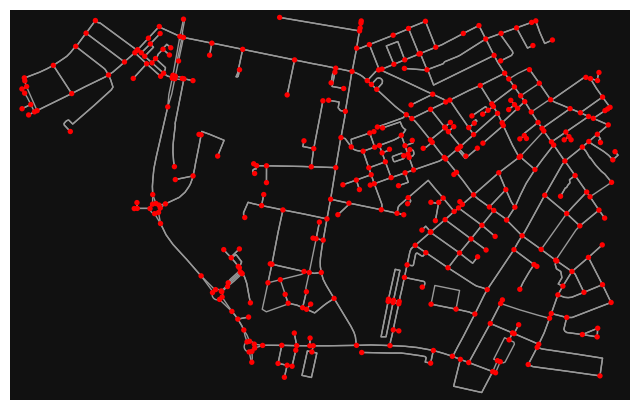

In [8]:
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43
# define a bounding box around ITU
north, south, east, west = 55.6646, 55.6540, 12.5767, 12.6077

# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
ox.plot_graph(G, node_color="r");

#### Method #2: Pass a lat-lng point and bounding box distance in meters
This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. [Here's a useful tool for defining bboxes](https://bboxfinder.com)

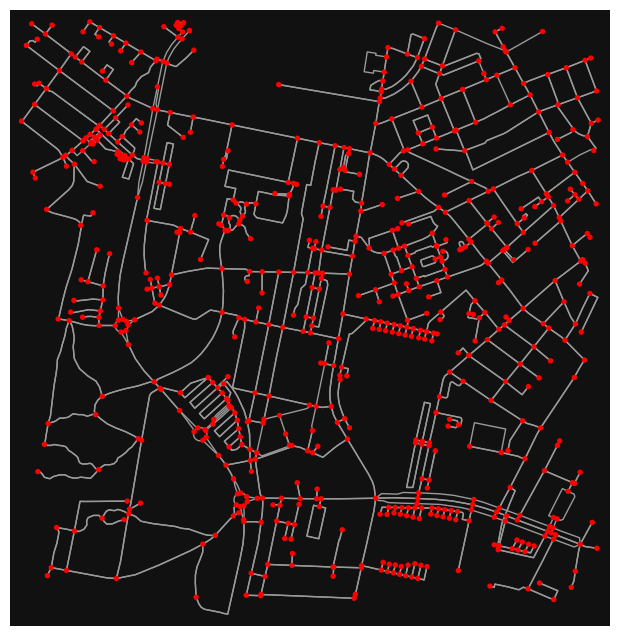

In [9]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)
# define a point at ITU
location_point = (55.659323, 12.591472)

# create bikeable network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(location_point, dist=750, dist_type="bbox", network_type="bike")
ox.plot_graph(G, node_color="r");

#### Method #3: Pass a lat-lng point and *network* distance in meters ####

This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. Then it truncates the network by removing all nodes further than *n* meters from the point along the network.

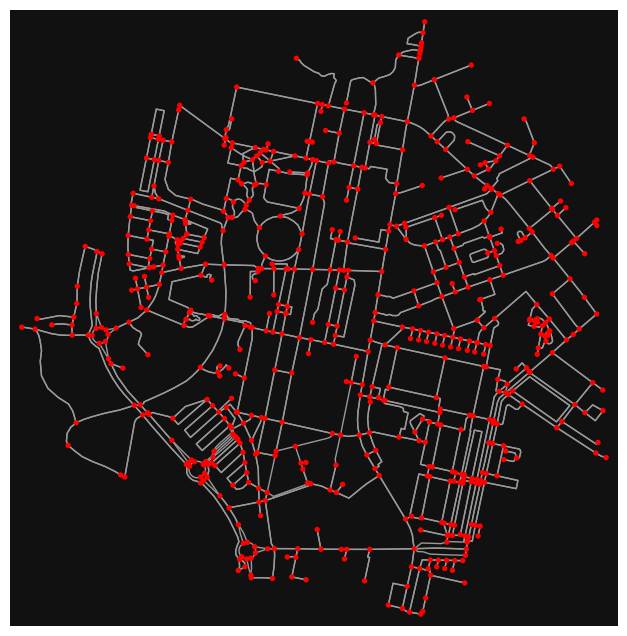

In [10]:
# same point again, but create network only of nodes within 750m along the network from point
G1 = ox.graph_from_point(location_point, dist=750, dist_type="network")
ox.plot_graph(G1, node_color="r");

*Note* the plot above shows the network within 500m (traveling distance along the network) from the `location_point`. By default, the `network_type` parameter value is `all`, meaning that we do not filter out paths that restrict certain types of traffic. This also means that one-way streets are honored as one-way and you cannot travel the wrong direction down them. Thus, the 500m takes into account only those nodes you can reach within 500m while only traveling in the allowed direction of the street. Instead (below), we can specify `network_type='walk'` to build a street network only of paths that walking is allowed on. This also makes every path bi-directional in the directed network, because you can walk in either direction on the sidewalk of a one-way street. Thus, the 500m now takes into account those nodes you can reach within 500m while traveling in either direction (even if it's a one-way street).

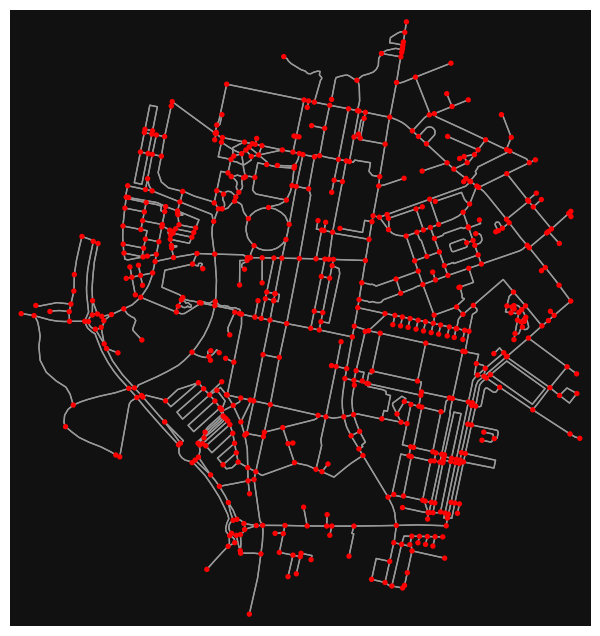

In [11]:
# create network only of nodes within 750m walking along the network from point
G2 = ox.graph_from_point(location_point, dist=750, dist_type="network", network_type="walk")
ox.plot_graph(G2, node_color="r");

#### Method #4, Pass an address and distance (*bounding box* or *network*) in meters ####
This geocodes the address, creates a bounding box, downloads the network, then truncates it by network distance (if distance_type='network').

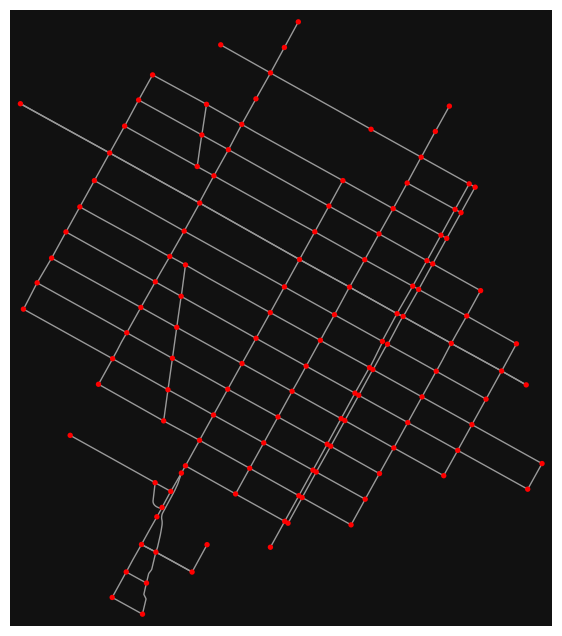

In [13]:
# network from address, including only nodes within 1km along the network from the address
G = ox.graph_from_address(address="350 5th Ave, New York, NY", dist=1000, dist_type="network", network_type="drive")
ox.plot_graph(G, node_color="r");

#### Method #5: Pass a place name ####

This geocodes the place name, gets the place's boundary shape polygon and bounding box, downloads the network within the bounding box, then truncates it to the place's boundary polygon.

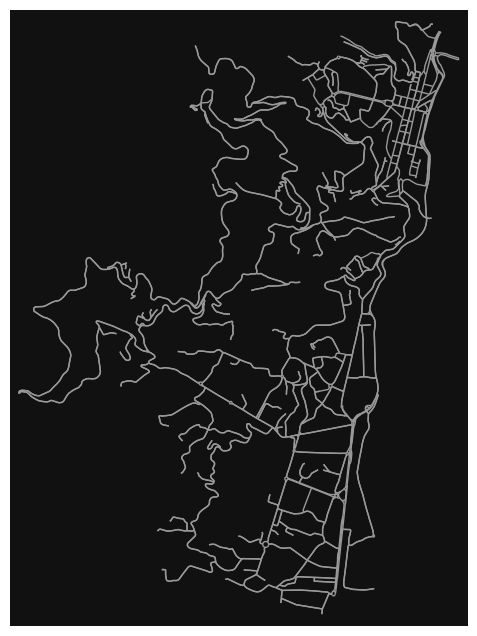

In [24]:
G = ox.graph_from_place("Bastia, Corsica", network_type="drive")
ox.plot_graph(G, node_color="none") # without plotting nodes

Be aware that this is a `MultiDiGraph`, i.e. a multigraph (parallel edges are possible) that is directed. Because there can be multiple links between a pair of nodes, each link is identified with a triple: (node1id, node2id, counter)

In [17]:
list(G.edges)[:10]

[(60370565, 338870652, 0),
 (60370565, 338870615, 0),
 (60370586, 338870618, 0),
 (60370599, 338870618, 0),
 (60370599, 60370602, 0),
 (60370602, 60370612, 0),
 (60370602, 60370599, 0),
 (60370612, 721266231, 0),
 (60370612, 60370602, 0),
 (60370622, 2358639572, 0)]

In [ ]:
# get the boundary polygon for Sarajevo, and plot it
city = ox.geocode_to_gdf("Sarajevo, Bosnia")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
ax.axis("off");

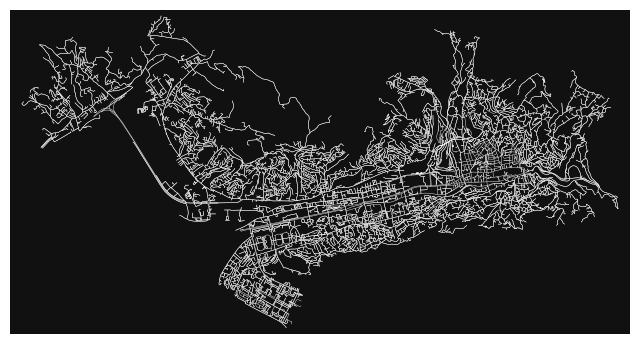

In [26]:
sarajevo = ox.geocode_to_gdf("Sarajevo, Bosnia")
polygon = sarajevo["geometry"].iloc[0]

G = ox.graph_from_polygon(polygon, network_type="drive_service")
ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.3);

## 4.1.3: Simplifying and Cleaning the Street Network Topology

Simplification is normally done by `OSMnx` automatically under the hood, but we can break it out to see how it works. OpenStreetMap nodes are weird. They include intersections, but they also include all the points along a single block where the street curves. The latter are not nodes in the graph theory sense, so we remove them algorithmically and consolidate the set of edges between "true" network nodes into a single edge. There are two simplification modes, strict and non-strict. The main difference is that unlike strict mode, non-strict mode allows simplification to an "expansion graph" (i.e., if the graph were undirected, nodes with degree 2 as long as the incident edges have different OSM IDs).

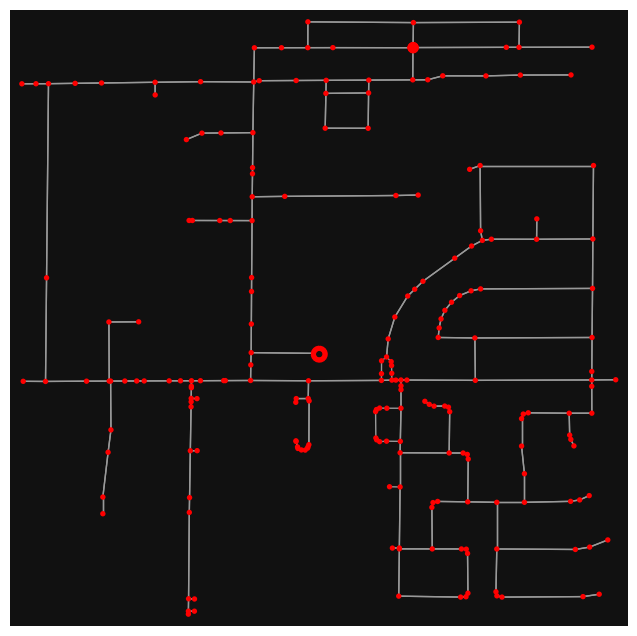

In [27]:
# create a network around some (lat, lng) point but do not simplify it yet
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, network_type="drive_service", dist=500, simplify=False)
ox.plot_graph(G, node_color="r");

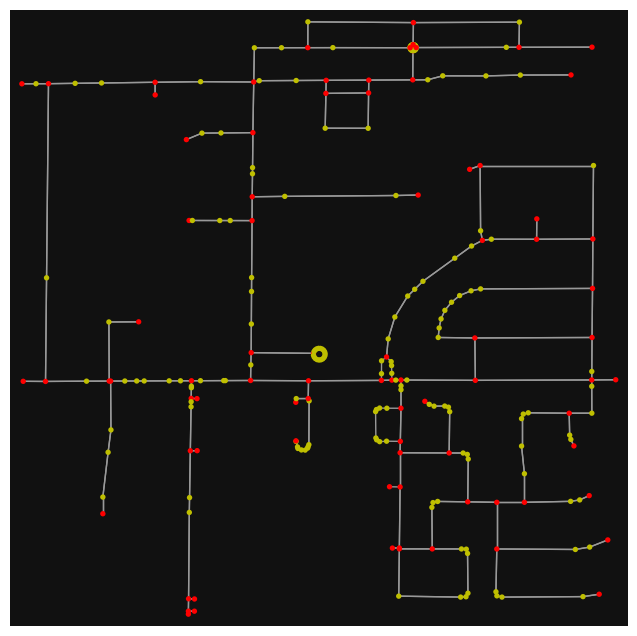

In [28]:
# turn off strict mode and see what nodes we'd remove, in yellow
colors = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=colors)

The yellow markers above are OSM nodes. We'll remove the nodes in yellow as they're not real network nodes (intersections/dead-ends).

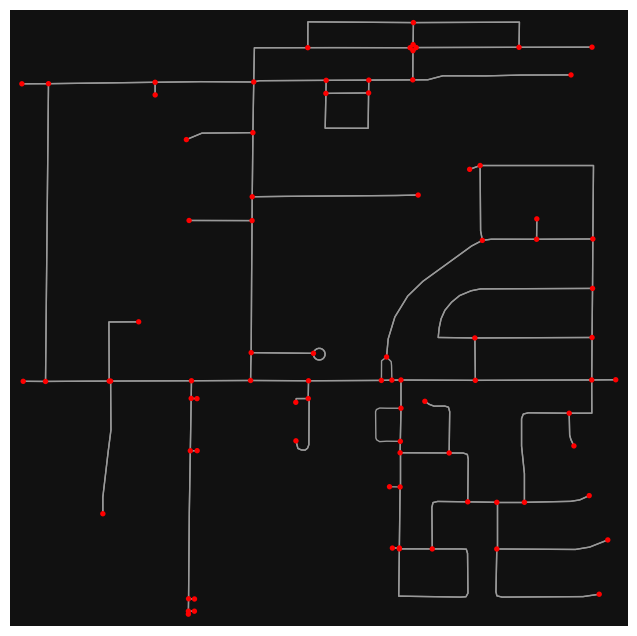

In [29]:
# simplify the network
G = ox.simplify_graph(G)
ox.plot_graph(G, node_color="r");

In [ ]:
G_fred.edges[576734, 576735, 0]

In [ ]:
# highlight all one-way edges in the Frederiksberg network from earlier
ec = ["r" if data["oneway"] else "w" for u, v, key, data in G_fred.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G_fred, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)

Above, notice all the peripheral stray edge stubs. Below, notice these are cleaned up and that the node degrees are accurate with regards to the wider street network that may extend beyond the limits of the requested area.

### OPTIONAL: Complex intersection consolidation

Many real-world street networks feature complex intersections and traffic circles, resulting in a cluster of graph nodes where there is really just one true intersection. Similarly, divided roads are often represented by separate centerline edges: the intersection of two divided roads thus creates 4 nodes, representing where each edge intersects a perpendicular edge, but these 4 nodes represent a single intersection in the real world. Traffic circles similarly create a cluster of nodes where each street's edge intersects the roundabout.

`OSMnx` can consolidate nearby intersections and optionally rebuild the graph's topology.

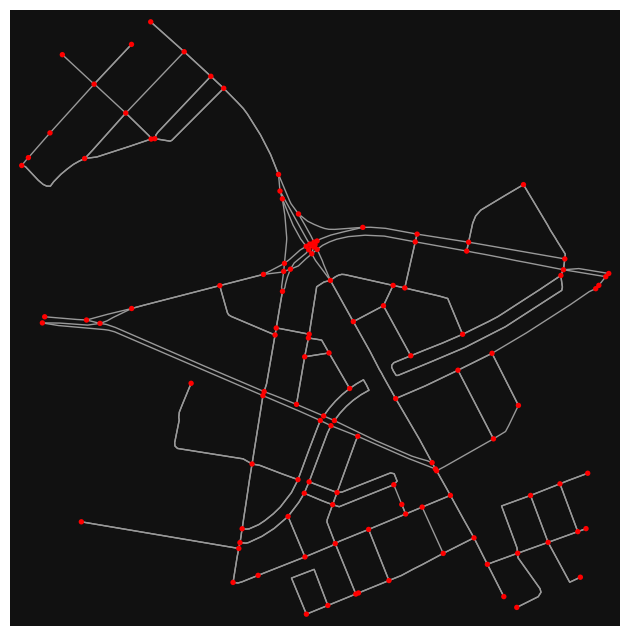

In [19]:
# get a street network and plot it with all edge intersections
point = 55.667708, 12.596266
G = ox.graph_from_point(point, network_type="drive", dist=500)
ox.plot_graph(G, node_color="r");

Notice the complex intersections creating clusters of nodes.

We'll specify that any nodes with 15 meter buffers of each other in this network are part of the same intersection. Adjust this tolerance based on the street design standards in the community you are examining, and use a projected graph to work in meaningful units like meters. We'll also specify that we do not want dead-ends returned in our list of consolidated intersections.

In [20]:
# get a GeoSeries of consolidated intersections
G_proj = ox.project_graph(G)
intersections = ox.consolidate_intersections(G_proj, rebuild_graph=False, tolerance=15, dead_ends=False)
len(intersections)

73

In [21]:
# compare to number of nodes in original graph
len(G)

122

Note that these cleaned up intersections give us more accurate intersection counts and densities, but do not alter or integrate with the network's topology.

To do that, we need to **rebuild the graph**.

In [22]:
# consolidate intersections and rebuild graph topology
# this reconnects edge geometries to the new consolidated nodes
cleaned = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
len(cleaned)

76

In [38]:
cleaned

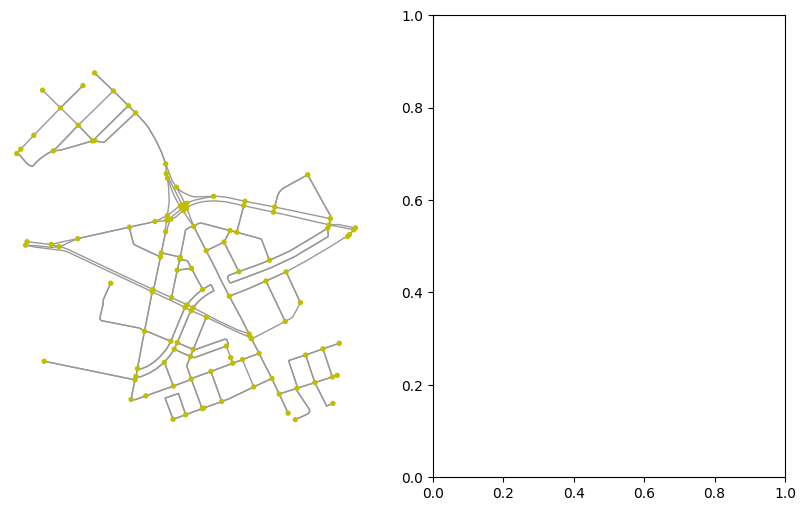

<Figure size 640x480 with 0 Axes>

(<Figure size 1000x600 with 2 Axes>, <Axes: >)

In [41]:
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 2, figsize=(10, 6))
ox.plot_graph(G_proj, node_color="y", ax  = axes[0])
ox.plot_graph(G_proj, node_color="r", ax = axes[1])

Notice how the traffic circles' many nodes are merged into a new single centroid node, with edge geometries extended to connect to it. Similar consolidation occurs at the intersection of the divided roads.

Running `consolidate_intersections` with `rebuild_graph=True` may yield somewhat (but not very) different intersection counts/densities compared to `rebuild_graph=False`. The difference lies in that the latter just merges buffered node points that overlap, whereas the former checks the topology of the overlapping node buffers before merging them.

This prevents topologically remote but spatially proximate nodes from being merged. For example:

  - A street intersection may lie directly below a freeway overpass's intersection with an on-ramp. We would not want to merge these together and connnect their edges: they are distinct junctions in the system of roads.
  - In a residential neighborhood, a bollarded street may create a dead-end immediately next to an intersection or traffic circle. We would not want to merge this dead-end with the intersection and connect their edges.

These examples illustrate (two-dimensional) geometric proximity, but topological remoteness. Accordingly, in some situations we may expect higher intersection counts when using `rebuild_graph=True` because it is more cautious with merging in these cases. The trade-off is that it has higher time complexity than `rebuild_graph=False`.

## 4.1.4 Routing, speed imputation, and travel times

Including parallelized shortest-path solving via built-in multiprocessing in OSMnx.

### Nearest node/edge search with OSMnx

The nearest_nodes and nearest_edges functions take arrays of x and y (or lng/lat) coordinates and return the nearest node/edge to each.

In [9]:
# randomly sample n points spatially-constrained to the network's geometry

G = ox.graph_from_place("Bastia, Corsica", network_type="drive")
G_undirected = ox.get_undirected(G)
france_epsg = "EPSG:27564"
G_undirected = ox.projection.project_graph(G_undirected, to_crs=france_epsg, to_latlong=False)

In [14]:
G_undirected == G

False

In [10]:
points = ox.utils_geo.sample_points(G_undirected, n=30)
X = points.x.values
Y = points.y.values
X0 = X.mean()
Y0 = Y.mean()

(points, X, Y, X0, Y0)

C:\Users\gfilo\AppData\Local\Temp\ipykernel_7836\3662536499.py:1: UserWarning: graph should be undirected to avoid oversampling bidirectional edges
  points = ox.utils_geo.sample_points(G_undirected, n=30)


(u           v            key
 8109853068  8109853120   0      POINT (580693.316 267733.998)
 294948665   506561923    0      POINT (582680.080 270320.154)
 1438772639  11014996710  0      POINT (582394.159 265976.467)
 60599736    3044478394   0      POINT (581344.337 266827.710)
 8077040107  8109853120   0      POINT (580730.781 267894.286)
 1097161519  1097161608   0      POINT (581684.520 266842.248)
 339821257   339821265    0      POINT (582361.370 269814.609)
 3044478756  3044478758   0      POINT (580989.218 267490.654)
 2121136952  2123756456   1      POINT (582444.112 270545.888)
 1376606261  8043243415   0      POINT (580922.697 269509.500)
 8132738641  8132738654   0      POINT (580109.867 267987.008)
 1798240599  1798240601   0      POINT (582123.512 266688.116)
 4200094862  4412996753   0      POINT (581939.244 270148.543)
 1914104890  2349194697   0      POINT (582274.583 270146.911)
 1376606201  3551025622   0      POINT (581577.077 268756.001)
 338870615   339875440   

In [15]:
# find each nearest node to several points, and optionally return distance
nodes, dists = ox.nearest_nodes(G_undirected, X, Y, return_dist=True)
(nodes[:4],dists[:4])

([338873887, 506561923, 11014996710, 60599736],
 [146.69035392203443,
  49.13961705084894,
  21.309839995427325,
  110.70030474623057])

In [ ]:
# or, find the nearest node to a single point
node = ox.nearest_nodes(G_undirected, X0, Y0)
node

In [16]:
# find each nearest edge to several points, and optionally return distance
edges, dists = ox.nearest_edges(G_undirected, X, Y, return_dist=True)
(edges[:4],dists[:4])

([(8109853068, 8109853120, 0),
  (294948665, 506561923, 0),
  (1438772639, 11014996710, 0),
  (60599736, 3044478394, 0)],
 [2.915340804266788e-11,
  4.884806594876319e-12,
  3.1703967132868956e-11,
  1.9422308223344297e-11])

In [17]:
# find the nearest edge to a single point
edge = ox.nearest_edges(G_undirected, X0, Y0)
edge

(339885415, 2820921969, 0)

## 2. Basic routing by distance

Pick two nodes. Then find the shortest path between origin and destination, using weight='length' to find the shortest path by minimizing distance traveled (otherwise it treats each edge as weight=1).

TypeError: 'NoneType' object is not subscriptable

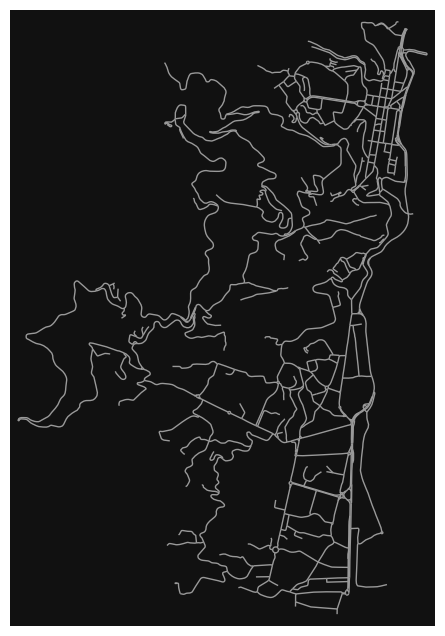

In [18]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G_undirected)[41]
dest = list(G_undirected)[220]
route = ox.shortest_path(G_undirected, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(G_undirected, route, route_color="y", route_linewidth=6, node_size=0)

Or get *k* shortest paths, weighted by some attribute:

In [ ]:
routes = ox.k_shortest_paths(G_fred, orig, dest, k=20, weight="length")
fig, ax = ox.plot_graph_routes(G_fred, list(routes), route_colors="y", route_linewidth=4, node_size=0)

## 3. Imputing travel speeds and times

The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

In [ ]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G_fred)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [ ]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

In [ ]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 30, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [ ]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G)[1]
dest = list(G)[120]
route1 = ox.shortest_path(G, orig, dest, weight="length")
route2 = ox.shortest_path(G, orig, dest, weight="travel_time")

In [ ]:
# plot the routes
fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [ ]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "length")))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "travel_time")))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "travel_time")))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

The yellow route minimizes travel time, and is thus longer but faster than the red route.

For more examples of travel time, see the [isochrones example](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb).

For more examples of routing, including using elevation as an impedance, see the [elevations example](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/12-node-elevations-edge-grades.ipynb).

## 4. Multiprocessing

Calculating lots of shortest paths can be slow, but OSMnx has built-in shortest path solver parallelization and multiprocessing, see: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/02-routing-speed-time.ipynb.

I suggest to use igraph as a much faster alternative: https://igraph.org/python/

# Custom filters and other infrastructure types

Use custom filters to fine-tune your network. OSMnx uses `network_type` presets to query for streets that allow walking, biking, driving, etc. You can override this by passing a `custom_filter` to specify specific OSM ways you want in your graph.

In [ ]:
place = {"city": "Berkeley", "state": "California"}

# only get motorway ways
cf = '["highway"~"motorway"]'
G = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
print(len(G), "motorway")
ox.plot_graph(G, node_color="r");

# only get primary ways
cf = '["highway"~"primary"]'
G = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
print(len(G), "primary")
ox.plot_graph(G, node_color="r");

# use the pipe (|) as 'or' operator
cf = '["highway"~"motorway|primary"]'
G = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
print(len(G), "motorway + primary")
ox.plot_graph(G, node_color="r");

In [ ]:
# network of the canals of amsterdam
place = "Amsterdam, Netherlands"
G = ox.graph_from_place(place, custom_filter='["waterway"~"canal"]')
ox.plot_graph(G, edge_color="c", edge_linewidth=2, node_size=0);

In [ ]:
# get NY subway rail network
# note this is rail *infrastructure* and thus includes crossovers, sidings, spurs, yards, etc
# for station-based rail network, you should download a station adjacency matrix elsewhere
ox.settings.useful_tags_way += ["railway"]
G = ox.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2);

To download the road network for an entire country, you often need to limit your query to something like motorways only, to fit in your computer's RAM. For large queries, such as the entire nation of Belgium, OSMnx will subdivide your query into multiple server requests to download all the data, then assemble the graph.

In [ ]:
# %%time
# # get only motorways, trunks, and their links in all of Belgium
# # takes a couple minutes to do all the downloading and processing
# # OSMnx automatically divides up the query into multiple requests to not overload server
# cf = '["highway"~"motorway|motorway_link|trunk|trunk_link"]'
# G = ox.graph_from_place("Belgium", network_type="drive", custom_filter=cf)
# ox.plot_graph(G, node_size=0);

Commented out because kernel dies in docker.

# pyrosm

Use pyrosm instead for large data sets or for more flxibility with custom filters: https://pyrosm.readthedocs.io/en/latest/basics.html#read-street-networks

In [ ]:
from pyrosm import OSM
from pyrosm import get_data
fp = get_data("helsinki_pbf")
# Initialize the OSM parser object
osm = OSM(fp)

In [ ]:
# Read POIs such as amenities and shops
# =====================================

# By default pyrosm reads all elements having "amenity", "shop" or "tourism" tag
# Here, let's read only "amenity" and "shop" by applying a custom filter that
# overrides the default filtering mechanism
custom_filter = {'amenity': True, "shop": True}
pois = osm.get_pois(custom_filter=custom_filter)

# Gather info about POI type (combines the tag info from "amenity" and "shop")
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

# Plot
ax = pois.plot(column='poi_type', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

In [ ]:
# Test reading all transit related data (bus, trains, trams, metro etc.)
# Exclude nodes (not keeping stops, etc.)
routes = ["bus", "ferry", "railway", "subway", "train", "tram", "trolleybus"]
rails = ["tramway", "light_rail", "rail", "subway", "tram"]
bus = ['yes']
transit = osm.get_data_by_custom_criteria(custom_filter={
                                        'route': routes,
                                        'railway': rails,
                                        'bus': bus,
                                        'public_transport': True},
                                        # Keep data matching the criteria above
                                        filter_type="keep",
                                        # Do not keep nodes (point data)    
                                        keep_nodes=False, 
                                        keep_ways=True, 
                                        keep_relations=True)
ax = transit.plot()
ax.axis("off");